In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.8.0")

Activated /home/rafserqui/Project.toml
Info Project name is quantecon-notebooks-julia, version is 0.8.0


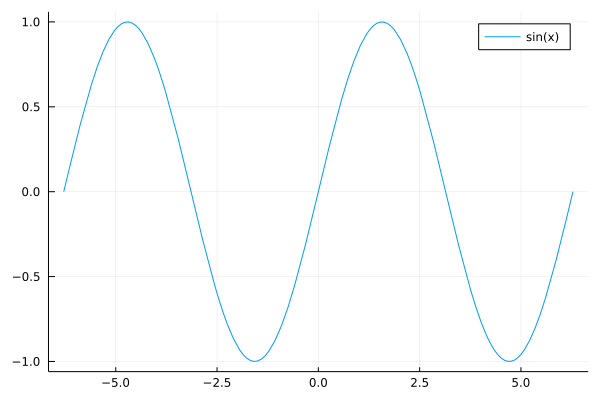

In [3]:
using Plots
gr(fmt=:png);

plot(sin, -2π, 2π, label="sin(x)")

# Plotting White Noise Process

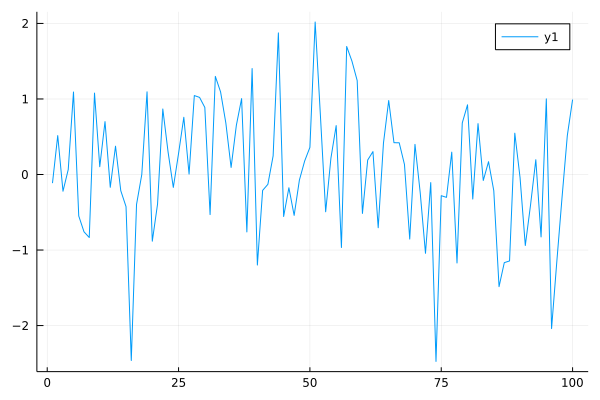

In [4]:
n = 100
ϵ = randn(n)
plot(1:n,ϵ)

In [5]:
typeof(ϵ)

Vector{Float64} (alias for Array{Float64, 1})

In [6]:
ϵ[1:3]

3-element Vector{Float64}:
 -0.11413631723078144
  0.5152638586115592
 -0.22135635399527206

## For Loops

In [7]:
# Bad programming style (I guess slower)
n = 100
ϵ = zeros(n)

for i in 1:n
    ϵ[i] = randn()
end

In [8]:
# Better way
n = 100
ϵ = zeros(n)

for i in eachindex(ϵ)
    ϵ[i] = randn()
end

## Loop Directly over Arrays

In [9]:
ϵ_sum = 0.0 # Notice declaring as float
m = 5

for ϵ_val in ϵ[1:m]
    ϵ_sum = ϵ_sum + ϵ_val
end

ϵ_mean = ϵ_sum / m

0.13043425786922996

In [17]:
# Alternatively, built in functions in Julia
using Statistics
ϵ_mean ≈ mean(ϵ[1:m])
ϵ_mean ≈ sum(ϵ[1:m]) / m

true

To write the approximate symbol, type `\approx[TAB]`

In [20]:
print(mean(ϵ[1:m]))

0.13043425786922996

## User Defined Functions

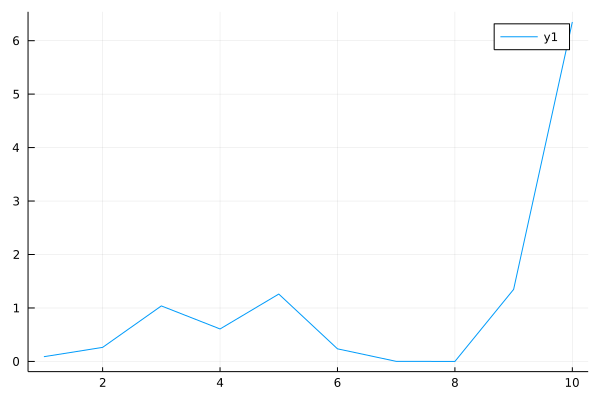

In [21]:
# Poor style
function generatedata(n)
    ϵ = zeros(n)
    for i in eachindex(ϵ)
        ϵ[i] = (randn())^2
    end
    return ϵ
end

data = generatedata(10)
plot(data)

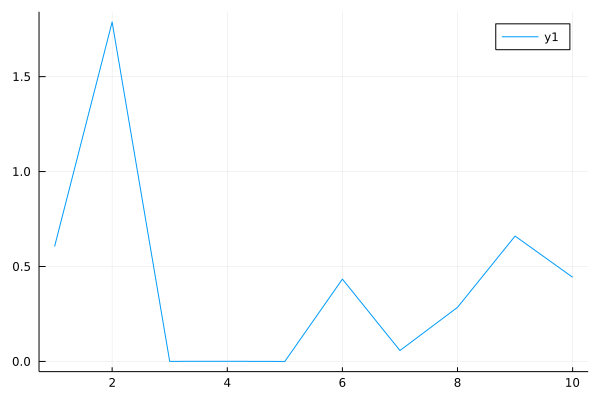

In [23]:
# Better style
function generatedata(n)
    ϵ = randn(n)
    return ϵ.^2
end

data = generatedata(10)
plot(data)

## Broadcasting Functions

In [24]:
f(x) = x^2 # Define function on a single line
generatedata(n) = f.(randn(n))
data = generatedata(10)

10-element Vector{Float64}:
 0.12564992076302384
 0.2826389184906018
 5.902566320194664
 1.2567888255460449
 0.05720961078986055
 0.9197942289465182
 0.19747064515091087
 0.8696326623058065
 0.47207828100049426
 0.8846027339584241

As a final – abstract – approach, we can make the `generatedata` function able to generically apply to a function.

In [26]:
generatedata(n, gen) = gen.(randn(n)) # uses broadcast for some function `gen`

f(x) = x^2
data = generatedata(5, f) # Apply f

5-element Vector{Float64}:
 1.2098133668393427
 3.62321882641184
 0.41214905755192976
 0.6143498898286948
 1.5708225507209534

High degrees of abstraction and generality, e.g. passing in a function f in this case, can make code either clearer or more confusing, but Julia enables you to use these techniques with **no performance overhead**.

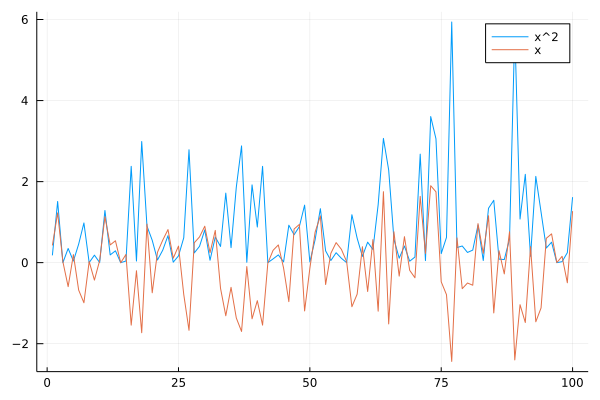

In [27]:
# Direct solution with broadcasting and small user-def function
n = 100
f(x) = x^2

x = randn(n)

plot(f.(x), label="x^2")
plot!(x, label = "x") # Layer on the same plot

## A Slightly More Useful Function

Pass choice of probability distribution and plot a histogram of observations

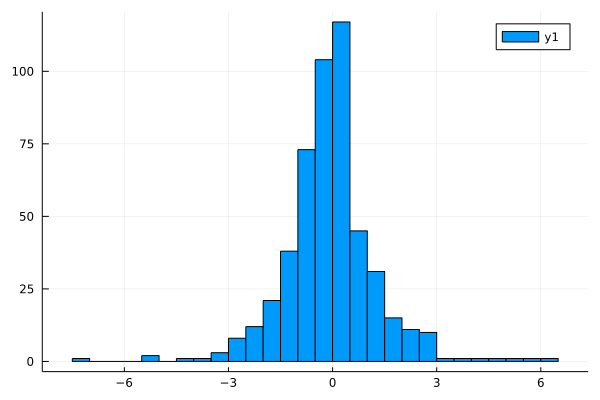

In [28]:
using Distributions

function plothistogram(distribution, n)
    ϵ = rand(distribution, n)
    histogram(ϵ)
end

lp = Laplace()
plothistogram(lp, 500)

Let’s have a casual discussion of how all this works while leaving technical details for later in the lectures.

First, `lp = Laplace()` creates an instance of a data type defined in the `Distributions` module that represents the Laplace distribution.

The name `lp` is bound to this value.

When we make the function call `plothistogram(lp, 500)` the code in the body of the function `plothistogram` is run with

- the name `distribution` bound to the same value as `lp`
- the name `n` bound to the integer `500`

### A mistery

Now consider the function call `rand(distribution, n)`.

This looks like something of a mystery.

The function `rand()` is defined in the base library such that rand(n) returns n uniform random variables on `n`

On the other hand, distribution points to a data type representing the Laplace distribution that has been defined in a third party package.

So how can it be that `rand()` is able to take this kind of value as an argument and return the output that we want?

The answer in a nutshell is **multiple dispatch**, which Julia uses to implement generic programming.

This refers to the idea that functions in Julia can have different behavior depending on the particular arguments that they’re passed.

Hence in Julia we can take an existing function and give it a new behavior by defining how it acts on a new type of value.

The compiler knows which function definition to apply to in a given setting by looking at the types of the values the function is called on.

In Julia these alternative versions of a function are called **methods**.

## While Loop

A fixed point problem

In [31]:
using LinearAlgebra

# Poor style
p = 1.0
β = 0.9
maxiter = 1e3
tolerance = 1.0e-13
v_iv = 0.8 #Initial condition

# Algorithm
v_old = v_iv
normdiff = Inf
iter = 1
while normdiff > tolerance && iter < maxiter
    v_new = p + β * v_old
    
    normdiff = norm(v_new - v_old)
    
    # Replace and continue
    v_old = v_new
    iter = iter + 1
end

println("Fixed point = $v_old, and |f(x) - x| = $normdiff in $iter iterations")

Fixed point = 9.999999999999167, and |f(x) - x| = 9.237055564881302e-14 in 286 iterations


In [33]:
# Implement as a function
function v_fp(β, p, v_iv, tolerance, maxiter)
    # Setup
    v_old = v_iv
    normdiff = Inf
    iter = 1
    while normdiff > tolerance && iter < maxiter
        v_new = p + β * v_old
        
        normdiff = norm(v_new - v_old)
        
        # Replace and continue
        v_old = v_new
        iter = iter + 1
    end
    return (v_old, normdiff, iter) # Return a tuple
end

p = 1.0
β = 0.9
maxiter = 1000
tolerance = 1.0e-7
v_initial = 0.8

v_star, normdiff, iter = v_fp(β, p, v_initial, tolerance, maxiter)
println("Fixed point = $v_star, and |f(x) - x| = $normdiff in $iter iterations")

Fixed point = 9.999999173706609, and |f(x) - x| = 9.181037796679448e-8 in 155 iterations


### Passing a Function

The fixed point map is a generic algorithm, while the function is particular to our problem. Generate the algorithm to take a function as an input.

In [34]:
function fixedpointmap(f, iv, tolerance, maxiter)
    x_old = iv
    normdiff = Inf
    iter = 1
    while normdiff > tolerance && iter < maxiter
        x_new = f(x_old)
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter = iter + 1
    end
    return (x_old, normdiff, iter)
end

p = 1.0
β = 0.9

f(v) = p + β * v

maxiter = 1000
tolerance = 1.0e-7
v_initial = 0.8

v_star, normdiff, iter = fixedpointmap(f, v_initial, tolerance, maxiter)
println("Fixed point = $v_star, and |f(x) - x| = $normdiff in $iter iterations")

Fixed point = 9.999999173706609, and |f(x) - x| = 9.181037796679448e-8 in 155 iterations


## Named Arguments and Return Values

In [35]:
function fixedpointmap(f; iv, tolerance=1E-7, maxiter=1000)
    x_old = iv
    normdiff = Inf
    iter = 1
    while normdiff > tolerance && iter < maxiter
        x_new = f(x_old)
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter = iter + 1
    end
    return (value = x_old, normdiff = normdiff, iter = iter) # Named tuple
end

fixedpointmap (generic function with 2 methods)

In [36]:
# define a map and parameters
p = 1.0
β = 0.9
f(v) = p + β * v # note that p and β are used in the function!

sol = fixedpointmap(f, iv=0.8, tolerance=1.0E-8) # don't need to pass
println("Fixed point = $(sol.value), and |f(x) - x| = $(sol.normdiff) in $(sol.iter)"*
        " iterations")

Fixed point = 9.999999918629035, and |f(x) - x| = 9.041219328764782e-9 in 177 iterations


In this example, all function parameters after the `;` in the list, must be called by name.

Furthermore, a default value may be enabled – so the named parameter `iv` is required while `tolerance` and `maxiter` have default values.

The return type of the function also has named fields, `value`, `normdiff`, and `iter` – all accessed intuitively using `.`.

### Illustration with Logistic Map

In [37]:
r = 2.0
f(x) = r * x * (1 - x)

sol = fixedpointmap(f, iv=0.8)
println("Fixed point = $(sol.value), and |f(x) - x| = $(sol.normdiff) in $(sol.iter) iterations")

Fixed point = 0.4999999999999968, and |f(x) - x| = 3.979330237546819e-8 in 7 iterations


## Using Packages

In [39]:
using NLsolve

p = 1.0
f(v) = p .+ β * v # Broadcast the +

sol = fixedpoint(f, [0.8])
println("Fixed point = $(sol.zero), and |f(x) - x| = $(norm(f(sol.zero) - sol.zero)) in $(sol.iterations) iterations")

Fixed point = [9.999999999999972], and |f(x) - x| = 3.552713678800501e-15 in 3 iterations


The `fixedpoint` function from the `NLsolve.jl` library implements the simple fixed point iteration scheme above.

Since the `NLsolve` library only accepts vector based inputs, we needed to make the `f(v)` function broadcast on the `+` sign, and pass in the initial condition as a vector of length 1 with `[0.8]`.

While a key benefit of using a package is that the code is clearer, and the implementation is tested, by using an orthogonal library we also enable performance improvements.

# Exercise

Simulate a plot for the correlated series

$$
x_{t+1} = \alpha x_t + \epsilon_{t+1} \text{ where } x_0 = 0 \text{ and } t=0,\ldots,n
$$

The sequence $\{\epsilon_t\}$ is assumed iid and standard normal. Set $n = 200$ and $\alpha = 0.2$

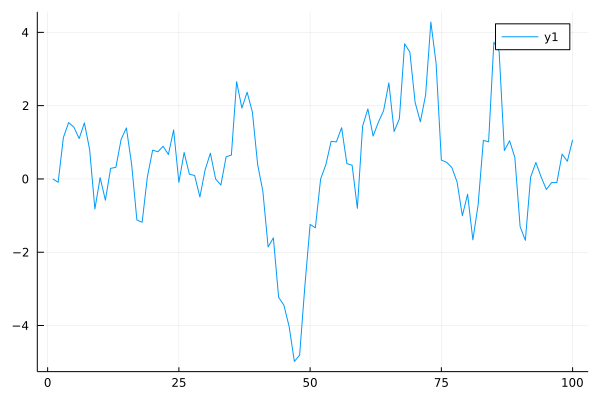

In [47]:
function corr_series(α,n)
    ϵ = randn(n)
    x = zeros(n)
    for t in eachindex(ϵ)
        if t < n
            x[t+1] = α .* x[t] .+ ϵ[t+1]
        end
    end
    return x
end

n = 100
α = 0.9
xt = corr_series(α, n)
plot(xt)